<a href="https://colab.research.google.com/github/AnitaTasnim/gtr_task/blob/main/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#fghhh


In [ ]:
!pip install yfinance pandas numpy matplotlib


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

class GoldenCrossTrader_:
    def __init__(self, symbol: str, start_date: str, end_date: str, capital: float = 5000):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.capital = capital
        self.data = None
        self.position = False
        self.shares = 0
        self.cash = capital
        self.trades = []

    #      Download Data
    def download_data(self):
        df = yf.download(self.symbol, start=self.start_date, end=self.end_date, progress=False)
        df = df.drop_duplicates().ffill()
        self.data = df
        print(f"[INFO] Downloaded {len(df)} rows for {self.symbol}")

    #      MAs
    def prepare_data(self):
        self.data["MA50"] = self.data["Close"].rolling(window=50).mean()
        self.data["MA200"] = self.data["Close"].rolling(window=200).mean()
        self.data.dropna(inplace=True)
        print("[INFO] Moving averages calculated")

    #  signals
    def generate_signals(self):
        self.data["Signal"] = np.where(self.data["MA50"] > self.data["MA200"], 1, 0)
        self.data["Position"] = self.data["Signal"].diff().fillna(0)
        print("[INFO] Signals generated")

        # Simulate Trades
    def simulate_trades(self):
        prev_price = None
        for date, row in self.data.iterrows():
            #  safer element access
            price = float(row["Close"].item()) if hasattr(row["Close"], "item") else float(row["Close"])
            signal = int(row["Position"].item()) if hasattr(row["Position"], "item") else int(row["Position"])

            # BUY (Golden Cross)
            if signal == 1 and not self.position:
                self.shares = int(self.cash // price)
                if self.shares > 0:
                    cost = self.shares * price
                    self.cash -= cost
                    self.position = True
                    prev_price = price
                    self.trades.append((date, "BUY", price, self.shares, self.cash))
                    print(f"[BUY] {self.shares} shares at {price:.2f} on {date.date()} | Cash left: {self.cash:.2f}")

            # SELL (Death Cross)
            elif signal == -1 and self.position:
                proceeds = self.shares * price
                self.cash += proceeds
                profit = (price - prev_price) * self.shares if prev_price else 0
                self.trades.append((date, "SELL", price, self.shares, self.cash, profit))
                self.position = False
                print(f"[SELL] {self.shares} shares at {price:.2f} on {date.date()} | Cash: {self.cash:.2f} | Profit: {profit:.2f}")
                self.shares = 0

        # Force close any open position
        if self.position:
            final_price = float(self.data.iloc[-1]["Close"].item()) if hasattr(self.data.iloc[-1]["Close"], "item") else float(self.data.iloc[-1]["Close"])
            proceeds = self.shares * final_price
            self.cash += proceeds
            profit = (final_price - prev_price) * self.shares if prev_price else 0
            self.trades.append((self.data.index[-1], "FORCE_SELL", final_price, self.shares, self.cash, profit))
            print(f"[FORCE SELL] Closed remaining position at {final_price:.2f} | Profit: {profit:.2f}")
            self.position = False


    def summary(self):
        profit = self.cash - self.capital
        percent_return = (profit / self.capital) * 100
        print("\n--- Trading Summary ---")
        print(f"Final Cash Balance: ${self.cash:.2f}")
        print(f"Total Profit/Loss: ${profit:.2f}")
        print(f"Return: {percent_return:.2f}%")
        return profit, percent_return





In [ ]:
if __name__ == "__main__":
    trader = GoldenCrossTrader("AAPL", "2018-01-01", "2023-12-31", 5000)
    trader.download_data()
    trader.prepare_data()
    trader.generate_signals()
    trader.simulate_trades()
    trader.summary()


/tmp/ipython-input-496187569.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.symbol, start=self.start_date, end=self.end_date, progress=False)


[INFO] Downloaded 1509 rows for AAPL
[INFO] Moving averages calculated
[INFO] Signals generated
[BUY] 100 shares at 49.82 on 2019-05-06 | Cash left: 18.19
[SELL] 100 shares at 142.92 on 2022-06-03 | Cash: 14310.41 | Profit: 9310.41
[BUY] 96 shares at 148.43 on 2022-09-26 | Cash left: 61.42
[SELL] 96 shares at 137.91 on 2022-10-07 | Cash: 13301.07 | Profit: -1009.35
[BUY] 85 shares at 155.87 on 2023-03-22 | Cash left: 51.89
[FORCE SELL] Closed remaining position at 190.91 | Profit: 2978.49

--- Trading Summary ---
Final Cash Balance: $16279.55
Total Profit/Loss: $11279.55
Return: 225.59%


/usr/local/lib/python3.12/dist-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/usr/local/lib/python3.12/dist-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(y))
/usr/local/lib/python3.12/dist-packages/matplotlib/text.py:568: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


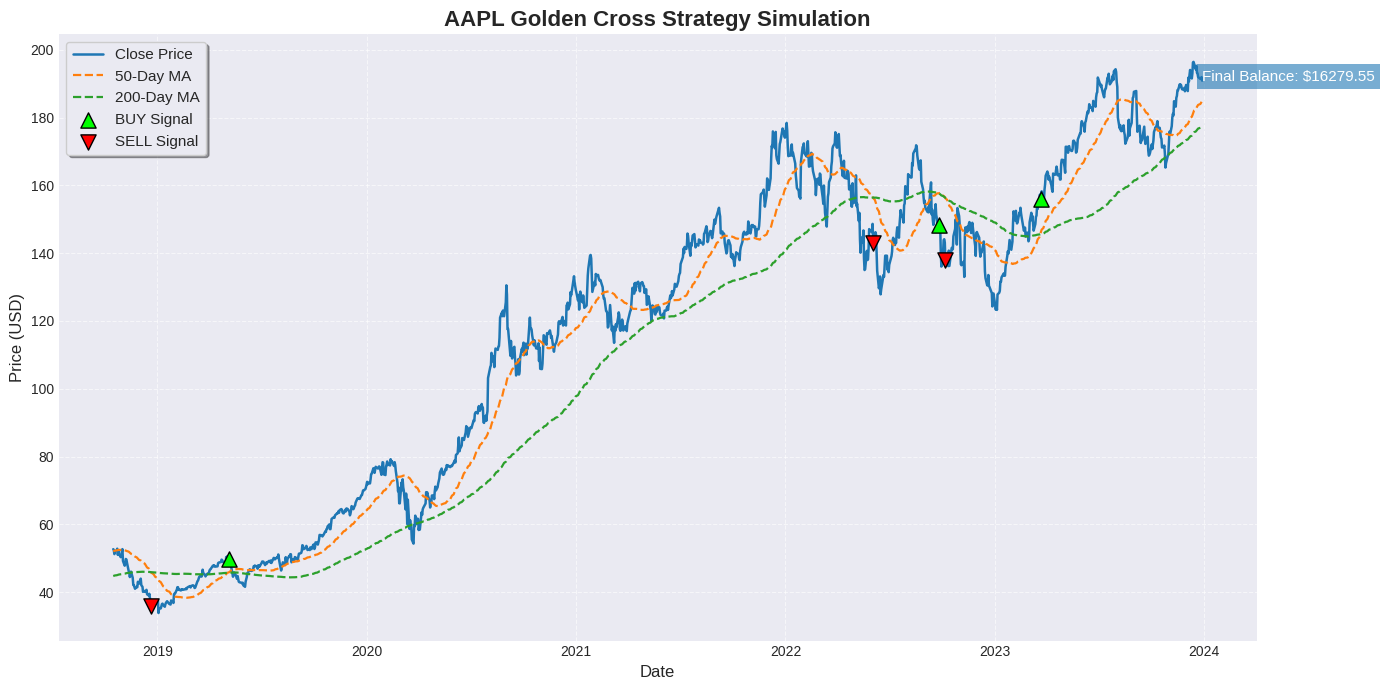

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14,7))

#  price and moving avg
plt.plot(trader.data.index, trader.data['Close'],
         label='Close Price', color='#1f77b4', linewidth=1.8)
plt.plot(trader.data.index, trader.data['MA50'],
         label='50-Day MA', color='#ff7f0e', linestyle='--', linewidth=1.6)
plt.plot(trader.data.index, trader.data['MA200'],
         label='200-Day MA', color='#2ca02c', linestyle='--', linewidth=1.6)

# buy and sell signals
buy_points = trader.data[trader.data["Position"] == 1]
sell_points = trader.data[trader.data["Position"] == -1]

plt.scatter(buy_points.index,
            trader.data.loc[buy_points.index, "Close"],
            marker='^', color='#00FF00', edgecolor='black', s=120,
            label='BUY Signal', zorder=5)

plt.scatter(sell_points.index,
            trader.data.loc[sell_points.index, "Close"],
            marker='v', color='#FF0000', edgecolor='black', s=120,
            label='SELL Signal', zorder=5)


plt.title(f"{trader.symbol} Golden Cross Strategy Simulation", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend(fontsize=11, loc='upper left', frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))



plt.text(trader.data.index[-1],
         trader.data['Close'].iloc[-1],
         f"Final Balance: ${trader.cash:.2f}",
         color='white', fontsize=11,
         bbox=dict(facecolor='#1f77b4', alpha=0.6, edgecolor='none'))

plt.tight_layout()
plt.show()


In [ ]:
pd.DataFrame(trader.trades, columns=["Date","Action","Price","Shares","Cash","Profit"]).to_csv("trades_log.csv", index=False)
print("✅ Trade log exported as trades_log.csv")


✅ Trade log exported as trades_log.csv
